In [24]:

import types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# BELOW WILL CHANGE, LET WSC DO IT, INSERT A PANDAS DATAFRAME FROM WSC RIGHT PANEL

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
client_cd2b4da6124b412ca5f9475fdf58e03e = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='x3xULBcOnr9siugAPQH3U50p7PcBw8mEWWQMOWZYyZAY',
    ibm_auth_endpoint="https://iam.ng.bluemix.net/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3-api.us-geo.objectstorage.service.networklayer.com')

body = client_cd2b4da6124b412ca5f9475fdf58e03e.get_object(Bucket='demoopenscale-donotdelete-pr-s0tkb6wsglvi48',Key='credit_risk_training.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_data = pd.read_csv(body)
df_data.head()


,CheckingStatus,LoanDuration,CreditHistory,LoanPurpose,LoanAmount,ExistingSavings,EmploymentDuration,InstallmentPercent,Sex,OthersOnLoan,...,OwnsProperty,Age,InstallmentPlans,Housing,ExistingCreditsCount,Job,Dependents,Telephone,ForeignWorker,Risk
0,0_to_200,31,credits_paid_to_date,other,1889,100_to_500,less_1,3,female,none,...,savings_insurance,32,none,own,1,skilled,1,none,yes,No Risk
1,less_0,18,credits_paid_to_date,car_new,462,less_100,1_to_4,2,female,none,...,savings_insurance,37,stores,own,2,skilled,1,none,yes,No Risk
2,less_0,15,prior_payments_delayed,furniture,250,less_100,1_to_4,2,male,none,...,real_estate,28,none,own,2,skilled,1,yes,no,No Risk
3,0_to_200,28,credits_paid_to_date,retraining,3693,less_100,greater_7,3,male,none,...,savings_insurance,32,none,own,1,skilled,1,none,yes,No Risk
4,no_checking,28,prior_payments_delayed,education,6235,500_to_1000,greater_7,3,male,none,...,unknown,57,none,own,2,skilled,1,none,yes,Risk


In [25]:

credit_data = df_data

In [26]:
shape = credit_data.shape
print('credit_data shape:', shape)
print('num unique:')
print(credit_data.nunique())
print(credit_data['Risk'].unique())
print(credit_data.groupby('Risk').size())

credit_data shape: (5000, 21)
num unique:
CheckingStatus                 4
LoanDuration                  59
CreditHistory                  5
LoanPurpose                   11
LoanAmount                  3354
ExistingSavings                5
EmploymentDuration             5
InstallmentPercent             6
Sex                            2
OthersOnLoan                   3
CurrentResidenceDuration       6
OwnsProperty                   4
Age                           53
InstallmentPlans               3
Housing                        3
ExistingCreditsCount           4
Job                            4
Dependents                     2
Telephone                      2
ForeignWorker                  2
Risk                           2
dtype: int64
['No Risk' 'Risk']
Risk
No Risk    3330
Risk       1670
dtype: int64


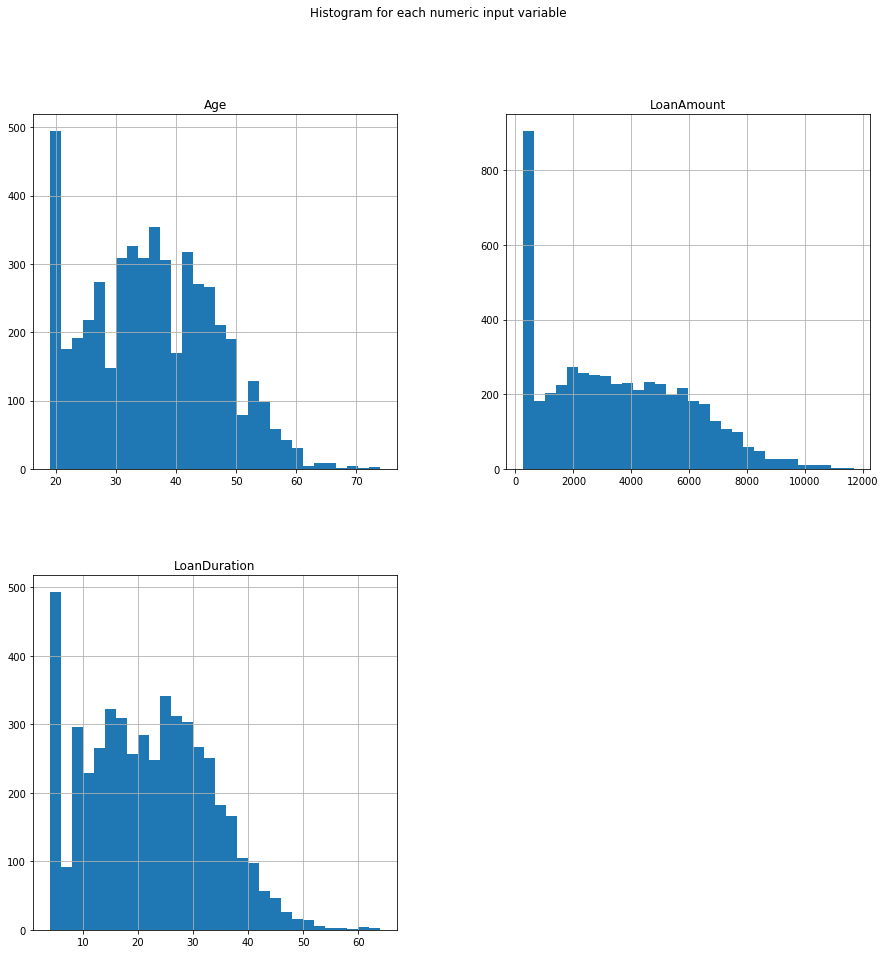

In [27]:
import pylab as pl
import matplotlib.pyplot as plt
%matplotlib inline

credit_data.drop(['CheckingStatus', 'CreditHistory', 'ExistingSavings', 'EmploymentDuration', 'InstallmentPercent', 'OthersOnLoan', 'CurrentResidenceDuration', 'OwnsProperty', 'InstallmentPlans', 'Housing', 'ExistingCreditsCount', 'Job', 'Dependents', 'Telephone', 'ForeignWorker'],axis=1).hist(bins=30, figsize=(15,15))
pl.suptitle("Histogram for each numeric input variable")
plt.savefig('num_hist')
plt.show()

In [33]:
del credit_data["CheckingStatus"]
del credit_data["CreditHistory"]
del credit_data["ExistingSavings"]
del credit_data["EmploymentDuration"]
del credit_data["InstallmentPercent"]
del credit_data["OthersOnLoan"]
del credit_data["CurrentResidenceDuration"]
del credit_data["OwnsProperty"]
del credit_data["InstallmentPlans"]
del credit_data["Housing"]
del credit_data["ExistingCreditsCount"]
del credit_data["Job"]
del credit_data["Dependents"]
del credit_data["Telephone"]
del credit_data["ForeignWorker"]
print(credit_data.nunique())

LoanDuration      59
LoanPurpose       11
LoanAmount      3354
Sex                2
Age               53
Risk               2
dtype: int64


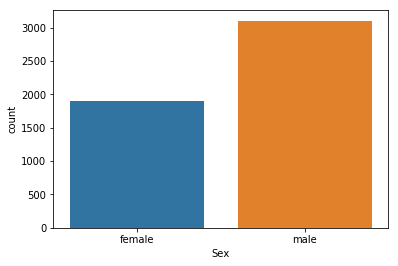

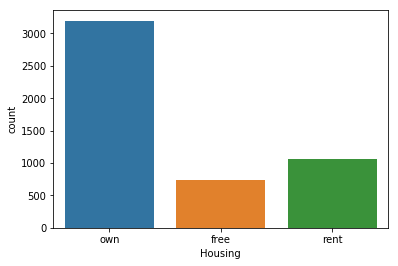

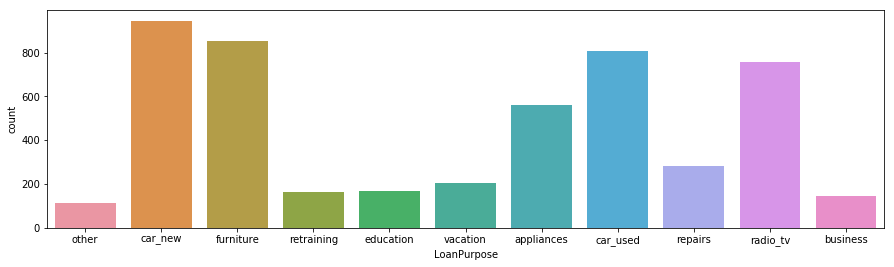

In [6]:
import seaborn as sns

sns.countplot(credit_data['Sex'], label="Count")
plt.show()

sns.countplot(credit_data['Housing'], label="Count")
plt.show()



plt.figure(figsize=(15,4))
sns.countplot(credit_data['LoanPurpose'], label="Count")
plt.show()

Divide customers from data into categories based on age to provide more relevant information
Separate by most likely university age, younger adult, older adult, or retired/senior

And, determine which examples are Risk or No Risk for future reference

In [34]:
interval = (18, 25, 40, 65, 100)
categories = ['University', 'Younger', 'Older', 'Senior']
credit_data["Age_by_Category"] = pd.cut(credit_data.Age, interval, labels=categories)
credit_good = credit_data[credit_data["Risk"] == 'No Risk']
credit_bad = credit_data[credit_data["Risk"] == 'Risk']

In [35]:
credit_data.head()

,LoanDuration,LoanPurpose,LoanAmount,Sex,Age,Risk,Age_by_Category
0,31,other,1889,female,32,No Risk,Younger
1,18,car_new,462,female,37,No Risk,Younger
2,15,furniture,250,male,28,No Risk,Younger
3,28,retraining,3693,male,32,No Risk,Younger
4,28,education,6235,male,57,Risk,Older


Function to perform OHE and Dummy Encoding

In [36]:
def one_hot(df, nan = False):
    original = list(df.columns)
    category = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns = category, dummy_na = nan, drop_first = True)
    new_columns = [c for c in df.columns if c not in original]
    return df, new_columns

In [37]:
credit_data = credit_data.merge(pd.get_dummies(credit_data['LoanPurpose'], drop_first=True, prefix='Purpose'), left_index=True, right_index=True)
credit_data = credit_data.merge(pd.get_dummies(credit_data['Sex'], drop_first=True, prefix='Sex'), left_index=True, right_index=True)

credit_data = credit_data.merge(pd.get_dummies(credit_data.Risk, prefix='Risk'), left_index=True, right_index=True)

credit_data = credit_data.merge(pd.get_dummies(credit_data["Age_by_Category"], drop_first=True, prefix='Age_by_Category'), left_index=True, right_index=True)

credit_data.head()

,LoanDuration,LoanPurpose,LoanAmount,Sex,Age,Risk,Age_by_Category,Purpose_business,Purpose_car_new,Purpose_car_used,...,Purpose_radio_tv,Purpose_repairs,Purpose_retraining,Purpose_vacation,Sex_male,Risk_No Risk,Risk_Risk,Age_by_Category_Younger,Age_by_Category_Older,Age_by_Category_Senior
0,31,other,1889,female,32,No Risk,Younger,0,0,0,...,0,0,0,0,0,1,0,1,0,0
1,18,car_new,462,female,37,No Risk,Younger,0,1,0,...,0,0,0,0,0,1,0,1,0,0
2,15,furniture,250,male,28,No Risk,Younger,0,0,0,...,0,0,0,0,1,1,0,1,0,0
3,28,retraining,3693,male,32,No Risk,Younger,0,0,0,...,0,0,1,0,1,1,0,1,0,0
4,28,education,6235,male,57,Risk,Older,0,0,0,...,0,0,0,0,1,0,1,0,1,0


In [38]:
import numpy as np
import sklearn as sk
credit_data['LoanAmount'] = np.log(credit_data['LoanAmount'])
credit_data.head()

,LoanDuration,LoanPurpose,LoanAmount,Sex,Age,Risk,Age_by_Category,Purpose_business,Purpose_car_new,Purpose_car_used,...,Purpose_radio_tv,Purpose_repairs,Purpose_retraining,Purpose_vacation,Sex_male,Risk_No Risk,Risk_Risk,Age_by_Category_Younger,Age_by_Category_Older,Age_by_Category_Senior
0,31,other,7.543803,female,32,No Risk,Younger,0,0,0,...,0,0,0,0,0,1,0,1,0,0
1,18,car_new,6.135565,female,37,No Risk,Younger,0,1,0,...,0,0,0,0,0,1,0,1,0,0
2,15,furniture,5.521461,male,28,No Risk,Younger,0,0,0,...,0,0,0,0,1,1,0,1,0,0
3,28,retraining,8.214194,male,32,No Risk,Younger,0,0,0,...,0,0,1,0,1,1,0,1,0,0
4,28,education,8.737934,male,57,Risk,Older,0,0,0,...,0,0,0,0,1,0,1,0,1,0


In [47]:
del credit_data["LoanPurpose"]
del credit_data["Sex"]
del credit_data["Age_by_Category"]

In [51]:
del credit_data["Risk"]

In [52]:
shape = credit_data.shape
print('credit_data shape:', shape)

credit_data shape: (5000, 19)


In [53]:
print('num unique:')
print(credit_data.nunique())

num unique:
LoanDuration                 59
LoanAmount                 3354
Age                          53
Purpose_business              2
Purpose_car_new               2
Purpose_car_used              2
Purpose_education             2
Purpose_furniture             2
Purpose_other                 2
Purpose_radio_tv              2
Purpose_repairs               2
Purpose_retraining            2
Purpose_vacation              2
Sex_male                      2
Risk_No Risk                  2
Risk_Risk                     2
Age_by_Category_Younger       2
Age_by_Category_Older         2
Age_by_Category_Senior        2
dtype: int64


In [54]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, fbeta_score
from sklearn.model_selection import GridSearchCV

# Algorithm models to use
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

In [55]:
X = credit_data.drop('Risk_Risk', axis = 1).values
y = credit_data["Risk_Risk"].values

print('X:', X)
print('y:', y)

X: [[31.          7.54380287 32.         ...  1.          0.
   0.        ]
 [18.          6.13556489 37.         ...  1.          0.
   0.        ]
 [15.          5.52146092 28.         ...  1.          0.
   0.        ]
 ...
 [32.          8.78508064 54.         ...  0.          1.
   0.        ]
 [38.          7.37588215 27.         ...  1.          0.
   0.        ]
 [12.          8.33134542 29.         ...  1.          0.
   0.        ]]
y: [0 0 0 ... 1 1 0]


In [56]:
from sklearn.model_selection import train_test_split, KFold, cross_val_score

# 80-20 data split between training and testing, set randomness
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=1)
seed = 5

print('X_train:', X_train)
print('y_train:', y_train)

print()

print('X_test:', X_test)
print('y_test:', y_test)

X_train: [[25.          7.81883244 35.         ...  1.          0.
   0.        ]
 [31.          8.18255926 23.         ...  0.          0.
   0.        ]
 [ 4.          8.16507926 27.         ...  1.          0.
   0.        ]
 ...
 [37.          8.60024675 39.         ...  1.          0.
   0.        ]
 [26.          8.272826   42.         ...  0.          1.
   0.        ]
 [16.          8.26384813 43.         ...  0.          1.
   0.        ]]
y_train: [0 0 0 ... 1 0 1]

X_test: [[24.          8.57753542 31.         ...  1.          0.
   0.        ]
 [49.          9.25894004 49.         ...  0.          1.
   0.        ]
 [25.          8.53385363 36.         ...  1.          0.
   0.        ]
 ...
 [35.          8.55198102 44.         ...  0.          1.
   0.        ]
 [10.          8.30548402 31.         ...  1.          0.
   0.        ]
 [17.          7.30317005 36.         ...  1.          0.
   0.        ]]
y_test: [0 1 1 0 0 0 0 1 1 0 0 0 0 0 1 0 0 1 1 0 1 0 1 0 0 0 0 0 0 

In [57]:
models = []

model1 = ('LR', LogisticRegression())  # Logistical regression
model2 = ('NB', GaussianNB())  # Naive Bayes
model3 = ('RF', RandomForestClassifier())  # Random Forest
model4 = ('SVM', SVC())  # Support Vector Machine
model5 = ('DT', DecisionTreeClassifier())  # Decision Tree
model6 = ('KN', KNeighborsClassifier())  # K Neighbors
model7 = ('MLP', MLPClassifier())  # Multi-Layer Perceptron

models.append(model1)
models.append(model2)
models.append(model3)
models.append(model4)
models.append(model5)
models.append(model6)
models.append(model7)

In [58]:
results = []
names = []

for name, model in models:
        kfold = KFold(n_splits=20, random_state=seed)
        cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring = 'recall')
        results.append(cv_results)
        names.append(name)
        print("%s: %f (%f)" % (name, cv_results.mean(), cv_results.std()))

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed

LR: 1.000000 (0.000000)
NB: 1.000000 (0.000000)


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/envs/Python36/lib/python3

RF: 1.000000 (0.000000)


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packa

SVM: 0.949969 (0.021954)
DT: 1.000000 (0.000000)
KN: 0.711647 (0.041359)
MLP: 1.000000 (0.000000)


In [59]:
model = GaussianNB()
trained_model_nb = model.fit(X_train, y_train)

In [71]:
!pip install update watson-machine-learning-client==1.0.378

     |████████████████████████████████| 542kB 14.3MB/s eta 0:00:01
  Found existing installation: watson-machine-learning-client 1.0.376
    Uninstalling watson-machine-learning-client-1.0.376:
      Successfully uninstalled watson-machine-learning-client-1.0.376


In [72]:
from watson_machine_learning_client import WatsonMachineLearningAPIClient

In [73]:
import json
import urllib3
import requests

In [75]:
wml_credentials = {
                   "url": "https://us-south.ml.cloud.ibm.com",
                   "apikey":"UBkwDf3BBnLwZWJ84S3pPVFM5AuHYI-j9rLzbe0_02BQ",
                   "instance_id": "017357e3-af97-414a-99d4-380b86b81a2e"
                  }

client = WatsonMachineLearningAPIClient(wml_credentials)

In [78]:
instance_details = client.service_instance.get_details()
print(instance_details)

{'metadata': {'guid': '017357e3-af97-414a-99d4-380b86b81a2e', 'url': 'https://us-south.ml.cloud.ibm.com/v3/wml_instances/017357e3-af97-414a-99d4-380b86b81a2e', 'created_at': '2020-02-17T04:31:29.109Z', 'modified_at': '2020-02-17T05:15:40.489Z'}, 'entity': {'source': 'Bluemix', 'published_models': {'url': 'https://us-south.ml.cloud.ibm.com/v3/wml_instances/017357e3-af97-414a-99d4-380b86b81a2e/published_models'}, 'usage': {'expiration_date': '2020-04-01T00:00:00.000Z', 'computation_time': {'limit': 1800000000, 'current': 0}, 'gpu_count_k80': {'limit': 8, 'current': 0}, 'model_count': {'limit': 200, 'current': 1}, 'gpu_count_p100': {'limit': 0, 'current': 0}, 'prediction_count': {'limit': 1000000, 'current': 1000}, 'capacity_units': {'limit': 1800000000, 'current': 1663039}, 'deployment_count': {'limit': 5, 'current': 1}, 'gpu_count_v100': {'limit': 0, 'current': 0}}, 'tags': [{'value': 'AI-OpenScale-Instance-40488f80-05b0-4f0e-a24d-a3c44135a2df', 'description': 'https://api.aiopenscale.c

In [79]:
print(client.repository.list())

------------------------------------  ----------------------------  ------------------------  ---------  -----------------
GUID                                  NAME                          CREATED                   FRAMEWORK  TYPE
66cb53d7-eead-458b-bb40-713e98d5f81b  training def for credit-risk  2020-02-17T05:13:34.169Z  mllib      definition
f3b68d43-837f-41fd-9bf7-81224516baa5  credit-risk                   2020-02-17T05:13:36.196Z  mllib-2.3  model
00ff0df2-7add-41da-a113-6e82145643e2  credit-risk-deploy            2020-02-17T05:15:40.018Z  mllib-2.3  online deployment
------------------------------------  ----------------------------  ------------------------  ---------  -----------------
None


In [80]:
model_props = {client.repository.ModelMetaNames.AUTHOR_NAME: "Ravi Srirangam",
               client.repository.ModelMetaNames.NAME: "CREDIT RISK PYTHON CLIENT DEMO",
               client.repository.DefinitionMetaNames.FRAMEWORK_NAME: 'scikit-learn',
               client.repository.DefinitionMetaNames.RUNTIME_NAME: 'python',
               client.repository.DefinitionMetaNames.RUNTIME_VERSION: '3.6'
               }

In [82]:
published_model = client.repository.store_model(model=trained_model_nb, meta_props=model_props)
published_model_uid = client.repository.get_model_uid(published_model)
print(published_model_uid)

4e272d42-c87b-4da5-8d79-43ae0a7ca329


# Create Deployments from the published model

In [83]:
created_deployment = client.deployments.create(
    published_model_uid, "CREDIT RISK PYTHON CLIENT DEMO FOR HCL")
scoring_endpoint = client.deployments.get_scoring_url(created_deployment)
print(scoring_endpoint)



#######################################################################################

Synchronous deployment creation for uid: '4e272d42-c87b-4da5-8d79-43ae0a7ca329' started

#######################################################################################


INITIALIZING
DEPLOY_SUCCESS


------------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_uid='e13f597c-8e75-44dc-ba54-30670d4d2c33'
------------------------------------------------------------------------------------------------


https://us-south.ml.cloud.ibm.com/v3/wml_instances/017357e3-af97-414a-99d4-380b86b81a2e/deployments/e13f597c-8e75-44dc-ba54-30670d4d2c33/online
